# [Using Explainable AI](https://github.com/slundberg/shap)

# [Using SHAP Values to Explain How Your Machine Learning Model Works](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137)

In [2]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import seaborn as sns
from numpy import sqrt, argsort
from tqdm import tqdm, trange

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

import xgboost
import shap

In [3]:
# load the data
data = pd.read_csv('DataSetForThesis2.csv')

del data["Discharge Flow (Nominal m3/hr)"]

# drop the second row
data = data.iloc[1:,:]

# check the missing values
print(f"Missing Values?: {data.isna().sum().any()}")

# drop the missing values
data.dropna(inplace=True)

print(f"Missing Values After Dropping?: {data.isna().sum().any()}")

# check the duplicates
print(f"Number Of Duplicates: {data.duplicated().sum()}")

print(" ")

# change the data type of the columns to float and date time 
cols=[i for i in data.columns if i not in ['Date/Time']]
for col in cols:
    data[col]=pd.to_numeric(data[col])
    
data['Date/Time'] = pd.to_datetime(data['Date/Time'])

data.head()

Missing Values?: True
Missing Values After Dropping?: False
Number Of Duplicates: 0
 


,Date/Time,Suction Pressure (Bar Gauge without Atmospheric pressure),Suction Flow (Nominal m3/hr),Suction Temperature (oC),Dischrage PreG1e without Atmospheric pressure),Discharge Temperature (oC),Gear Box Output Shaft Drive End (DE) X Vibration (μm),Gear Box Output Shaft Drive End (DE) Y Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Input Shaft Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Drive End (DE) X Vibration (μm),Gear Box Input Shaft Drive End (DE) Y Vibration (μm),Suction Vibration in x,Suction Vibration in y,Discharge Vibration in x,Discharge Vibration in y,Compressor speed (RPM)
1,2020-11-07 00:00:00,5.2,26812.4,28.5,7.4,55.2,3.0,4.0,5.0,6.8,6.6,6.60,6.9,7.4,9.727419,10.204235,7.166746,9.235712,8164.449219
2,2020-11-07 00:20:00,5.2,26836.2,28.4,7.4,55.2,3.0,4.0,5.1,7.0,6.7,6.54,6.8,7.5,9.721112,10.209536,7.135931,9.235712,8161.888184
3,2020-11-07 00:40:00,5.2,26856.7,28.3,7.4,55.2,3.1,4.0,5.3,7.3,6.7,6.46,5.7,7.4,9.714805,10.214835,7.105114,9.178102,8162.304688
4,2020-11-07 01:00:00,5.2,26800.2,28.2,7.4,55.2,3.1,4.0,5.1,7.1,6.8,6.49,7.6,7.4,9.708497,10.220136,7.074298,9.116689,8315.385742
5,2020-11-07 01:20:00,5.2,26852.4,28.1,7.4,55.3,3.1,4.2,5.0,6.7,6.7,6.61,7.6,7.5,9.702189,10.225435,7.043482,9.139559,8217.386719


In [12]:
data.iloc[:,1:]

,Suction Pressure (Bar Gauge without Atmospheric pressure),Suction Flow (Nominal m3/hr),Suction Temperature (oC),Dischrage PreG1e without Atmospheric pressure),Discharge Temperature (oC),Gear Box Output Shaft Drive End (DE) X Vibration (μm),Gear Box Output Shaft Drive End (DE) Y Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Input Shaft Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Drive End (DE) X Vibration (μm),Gear Box Input Shaft Drive End (DE) Y Vibration (μm),Suction Vibration in x,Suction Vibration in y,Discharge Vibration in x,Discharge Vibration in y,Compressor speed (RPM)
1,5.2,26812.4,28.5,7.4,55.2,3.0,4.0,5.0,6.8,6.6,6.60,6.9,7.4,9.727419,10.204235,7.166746,9.235712,8164.449219
2,5.2,26836.2,28.4,7.4,55.2,3.0,4.0,5.1,7.0,6.7,6.54,6.8,7.5,9.721112,10.209536,7.135931,9.235712,8161.888184
3,5.2,26856.7,28.3,7.4,55.2,3.1,4.0,5.3,7.3,6.7,6.46,5.7,7.4,9.714805,10.214835,7.105114,9.178102,8162.304688
4,5.2,26800.2,28.2,7.4,55.2,3.1,4.0,5.1,7.1,6.8,6.49,7.6,7.4,9.708497,10.220136,7.074298,9.116689,8315.385742
5,5.2,26852.4,28.1,7.4,55.3,3.1,4.2,5.0,6.7,6.7,6.61,7.6,7.5,9.702189,10.225435,7.043482,9.139559,8217.386719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26277,5.4,26471.1,30.1,7.3,28.4,0.9,0.7,0.7,0.6,0.7,0.65,0.7,0.7,0.906404,0.906404,0.951176,1.009405,0.000000
26278,5.4,26416.4,30.0,7.3,28.2,0.9,0.7,0.7,0.6,0.7,0.65,0.7,0.7,0.906404,0.906404,0.953478,1.009405,0.000000
26279,5.4,26412.1,29.8,7.4,28.0,0.9,0.7,0.7,0.7,0.7,0.65,0.7,0.7,0.906404,0.906404,0.955780,1.009405,0.000000
26280,5.4,26445.5,29.4,7.3,27.9,0.8,0.7,0.7,0.6,0.7,0.65,0.8,0.7,0.937772,0.956760,0.906404,0.989985,0.000000


In [14]:
values=data.shape[0]
training=0.67 #Use 0.8 for default
what_to_train=values*training

data2=data.iloc[:,1:19]
data2_date=data[['Date/Time']]

print("Training Sets")

data2_train=data2.iloc[0:int(what_to_train),0:]
data2_train.iloc[:,0:]=data2_train.iloc[:,0:].astype('float64')

data2_train.head()

Training Sets


,Suction Pressure (Bar Gauge without Atmospheric pressure),Suction Flow (Nominal m3/hr),Suction Temperature (oC),Dischrage PreG1e without Atmospheric pressure),Discharge Temperature (oC),Gear Box Output Shaft Drive End (DE) X Vibration (μm),Gear Box Output Shaft Drive End (DE) Y Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Input Shaft Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Drive End (DE) X Vibration (μm),Gear Box Input Shaft Drive End (DE) Y Vibration (μm),Suction Vibration in x,Suction Vibration in y,Discharge Vibration in x,Discharge Vibration in y,Compressor speed (RPM)
1,5.2,26812.4,28.5,7.4,55.2,3.0,4.0,5.0,6.8,6.6,6.60,6.9,7.4,9.727419,10.204235,7.166746,9.235712,8164.449219
2,5.2,26836.2,28.4,7.4,55.2,3.0,4.0,5.1,7.0,6.7,6.54,6.8,7.5,9.721112,10.209536,7.135931,9.235712,8161.888184
3,5.2,26856.7,28.3,7.4,55.2,3.1,4.0,5.3,7.3,6.7,6.46,5.7,7.4,9.714805,10.214835,7.105114,9.178102,8162.304688
4,5.2,26800.2,28.2,7.4,55.2,3.1,4.0,5.1,7.1,6.8,6.49,7.6,7.4,9.708497,10.220136,7.074298,9.116689,8315.385742
5,5.2,26852.4,28.1,7.4,55.3,3.1,4.2,5.0,6.7,6.7,6.61,7.6,7.5,9.702189,10.225435,7.043482,9.139559,8217.386719


In [37]:
print("Testing Sets")

data2_test=data2.iloc[int(what_to_train): ,0:]
data2_test.iloc[:,0:]=data2_test.iloc[:,0:].astype('float64')
data2_test.reset_index(inplace=False)

data2_test.head()

Testing Sets


,Suction Pressure (Bar Gauge without Atmospheric pressure),Suction Flow (Nominal m3/hr),Suction Temperature (oC),Dischrage PreG1e without Atmospheric pressure),Discharge Temperature (oC),Gear Box Output Shaft Drive End (DE) X Vibration (μm),Gear Box Output Shaft Drive End (DE) Y Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Input Shaft Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Drive End (DE) X Vibration (μm),Gear Box Input Shaft Drive End (DE) Y Vibration (μm),Suction Vibration in x,Suction Vibration in y,Discharge Vibration in x,Discharge Vibration in y,Compressor speed (RPM)
17609,5.3,26520.4,43.9,7.3,42.2,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.8,0.924903,0.965977,0.95676,1.009405,2217.723633
17610,5.3,26548.2,44.7,7.3,42.3,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.8,0.922801,0.963781,0.95676,1.009405,2218.327148
17611,5.3,26510.7,45.2,7.3,42.9,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.7,0.920698,0.961586,0.95676,1.009405,2218.930664
17612,5.3,26549.8,45.0,7.3,43.7,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.7,0.918596,0.959390,0.95676,1.009405,2219.534180
17613,5.3,26848.4,44.5,7.3,44.4,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.7,0.916493,0.957194,0.95676,1.008579,2220.137695


In [67]:
heading=["Suction Temperature (oC)"]

print(f"For this case we have {data2_train.shape[0]} Training Sets and {data2_test.shape[0]} Training Sets. and we will be focusing on the {heading}") 

For this case we have 17608 Training Sets and 8673 Training Sets. and we will be focusing on the ['Suction Temperature (oC)']


In [68]:
from sklearn.ensemble import RandomForestRegressor
# Prepares a default instance of the random forest regressor
model = RandomForestRegressor()

In [69]:
X_train=data2_train
y_train=data2_train[heading]
X_train, y_train=np.array(X_train), np.array(y_train)

In [70]:
print(X_train.shape)
print(y_train.shape)

(17608, 18)
(17608, 1)


In [71]:
X_test=data2_test
y_test=data2_test[heading]
X_test, y_test=np.array(X_test), np.array(y_test)

In [72]:
print(X_test.shape)
print(y_test.shape)

(8673, 18)
(8673, 1)


In [73]:
# Fits the model on the data
model.fit(X_train, y_train)

RandomForestRegressor()

In [74]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 8674it [29:26,  4.88it/s]                          


Bar Plot


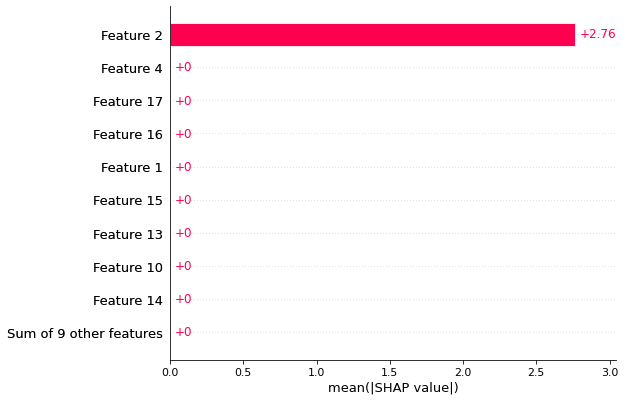

In [75]:
print("Bar Plot")
shap.plots.bar(shap_values)

Bee Swarm Plot


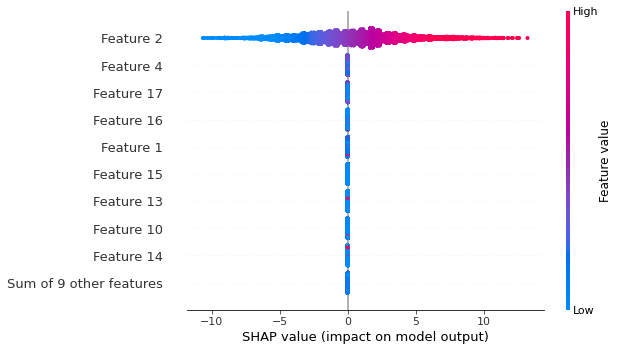

In [76]:
print("Bee Swarm Plot")
shap.plots.beeswarm(shap_values)

Violin Plot


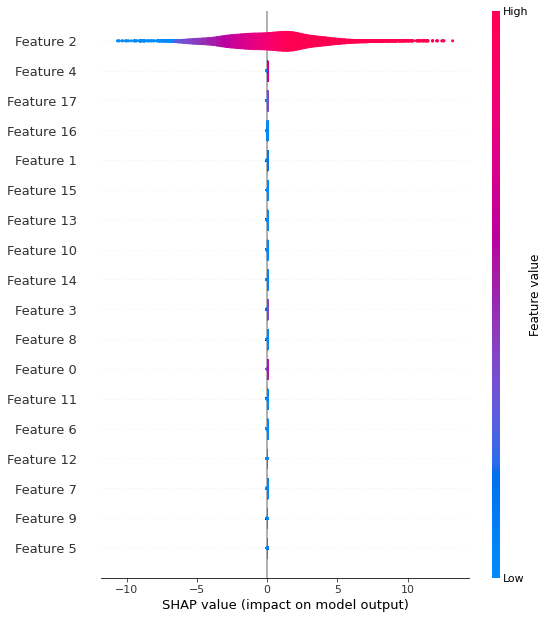

In [77]:
print("Violin Plot")
shap.summary_plot(shap_values, plot_type='violin')

Local Bar Plot


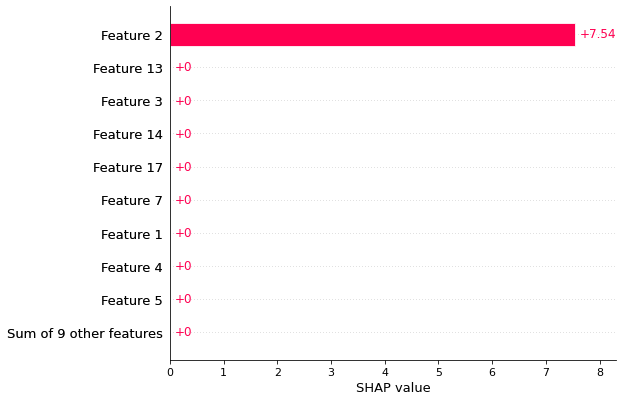

In [78]:
print("Local Bar Plot")
shap.plots.bar(shap_values[0])

Waterfall Plot


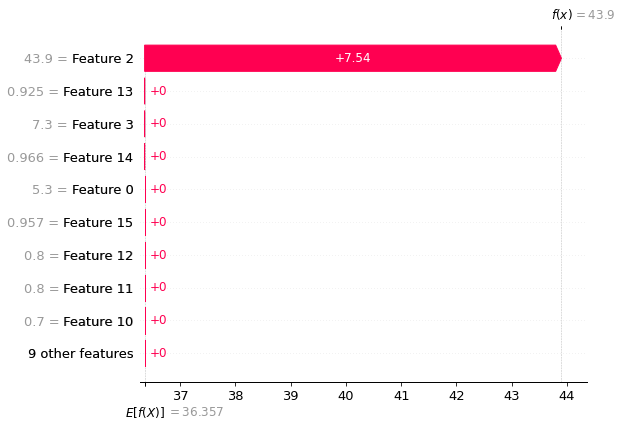

In [79]:
print("Waterfall Plot")
shap.plots.waterfall(shap_values[0])

In [80]:
# print("Force Plot")
# shap.plots.force(shap_test[0])